In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# For analysing Monte Carlo samples
import emcee
from emcee import EnsembleSampler

# For plotting Monte Carlo samples
from getdist import plots

In [2]:
file_path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES.dat"
df = pd.read_csv(file_path, delimiter='\s+')

df.shape

(1701, 47)

In [3]:
df.head(10)

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006
5,1981B,50,0.00317,0.00084,0.00350,0.00001,0.00236,0.00001,11.54160,0.613941,...,0.2973,41,43.2260,0.376420,0.0732,0.5763,0.0206,0.007,1.0,0.013
6,2013aa,56,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.20740,0.594070,...,0.1580,31,27.5263,0.645500,0.1104,0.5586,0.0298,0.003,1.0,0.003
7,2013aa,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.29980,0.579622,...,0.1190,56,35.0505,0.987280,0.0620,0.5586,0.0727,0.007,1.0,0.003
8,2017cbv,5,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.14830,0.577815,...,0.0381,94,69.7345,0.971300,0.0580,0.5586,0.0516,0.004,1.0,0.003
9,2017cbv,18,0.00331,0.00085,0.00478,0.00015,0.00411,0.00015,11.25770,0.577916,...,0.0500,92,45.1690,0.999990,0.0607,0.5586,0.0216,0.003,1.0,0.003


In [4]:
#  Verify the number of missing values in each column in this dataset
df.isna().sum()

CID                     0
IDSURVEY                0
zHD                     0
zHDERR                  0
zCMB                    0
zCMBERR                 0
zHEL                    0
zHELERR                 0
m_b_corr                0
m_b_corr_err_DIAG       0
MU_SH0ES                0
MU_SH0ES_ERR_DIAG       0
CEPH_DIST               0
IS_CALIBRATOR           0
USED_IN_SH0ES_HF        0
c                       0
cERR                    0
x1                      0
x1ERR                   0
mB                      0
mBERR                   0
x0                      0
x0ERR                   0
COV_x1_c                0
COV_x1_x0               0
COV_c_x0                0
RA                      0
DEC                     0
HOST_RA                 0
HOST_DEC                0
HOST_ANGSEP             0
VPEC                    0
VPECERR                 0
MWEBV                   0
HOST_LOGMASS            0
HOST_LOGMASS_ERR        0
PKMJD                   0
PKMJDERR                0
NDOF        

In [5]:
df.isnull().sum()

CID                     0
IDSURVEY                0
zHD                     0
zHDERR                  0
zCMB                    0
zCMBERR                 0
zHEL                    0
zHELERR                 0
m_b_corr                0
m_b_corr_err_DIAG       0
MU_SH0ES                0
MU_SH0ES_ERR_DIAG       0
CEPH_DIST               0
IS_CALIBRATOR           0
USED_IN_SH0ES_HF        0
c                       0
cERR                    0
x1                      0
x1ERR                   0
mB                      0
mBERR                   0
x0                      0
x0ERR                   0
COV_x1_c                0
COV_x1_x0               0
COV_c_x0                0
RA                      0
DEC                     0
HOST_RA                 0
HOST_DEC                0
HOST_ANGSEP             0
VPEC                    0
VPECERR                 0
MWEBV                   0
HOST_LOGMASS            0
HOST_LOGMASS_ERR        0
PKMJD                   0
PKMJDERR                0
NDOF        

We are interested in:

 - `df['zCMB']` CMB Corrected Redshift.
 - `df['zCMBERR']` CMB Corrected Redshift Uncertainty.
 - `df['m_b_corr']` corrected/standardized m_b magnitude.
 - `df['m_b_corr_err_DIAG']` corrected/standardized m_b magnitude uncertainty as determined from the diagonal of the covariance matrix. WARNING, DO NOT FIT COSMOLOGICAL PARAMETERS WITH THESE UNCERTAINTIES. YOU MUST USE THE FULL COVARIANCE. THIS IS ONLY FOR PLOTTING/VISUAL PURPOSES.

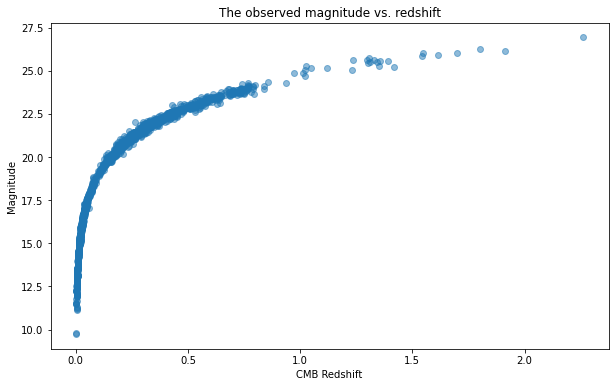

In [6]:
# Plot observed magnitude vs redshift CMB

plt.figure(figsize=(10, 6))
plt.scatter(df['zCMB'], df['m_b_corr'], alpha=0.5)
plt.title('The observed magnitude vs. redshift')
plt.xlabel('CMB Redshift')
plt.ylabel('Magnitude')
plt.grid(False)

plt.show()

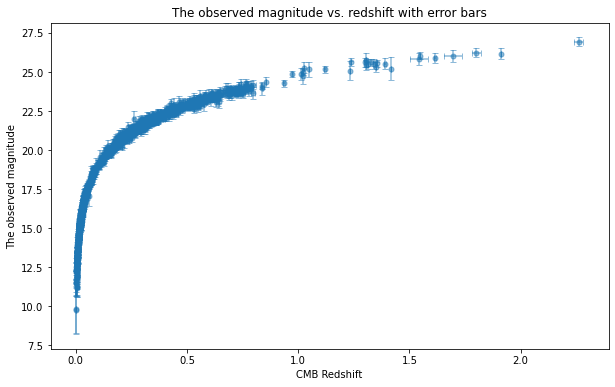

In [7]:
# Plot with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(df['zCMB'], df['m_b_corr'], xerr=df['zCMBERR'], yerr=df['m_b_corr_err_DIAG'], fmt='o', alpha=0.5,
             capsize=3, markersize=5)
plt.title('The observed magnitude vs. redshift with error bars')
plt.xlabel('CMB Redshift')
plt.ylabel('The observed magnitude')
plt.grid(False)

plt.show()

<AxesSubplot:>

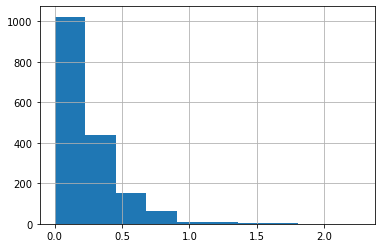

In [8]:
df['zCMB'].hist()

In [9]:
df['zCMB'].mean()

0.22108950617283932

In [10]:
df['zCMB'].min()

0.00122

In [11]:
df['zCMB'].max()

2.2613

## MCMC analysis using type Ia supernovae data


### The luminosity distance

The luminosity distance is a very important notion of distance for observation. It is based on the knowledge of the intrinsic luminosity _L_ of a source, which is therefore called _standard candle_. Type Ia supernovae are standard candles, for example.


The luminosity distance in a flat expanding Friedmann-Lemaitre-Robertson-Walker universe is defined as:

$$
d(z)=\frac{c}{H_0}\left[z+\frac{1}{2}(1-q_0)z^2-\frac{1}{6}(3q_0^2+q_0-j_0-1)(z^3)\right], 
$$

where $H_0$ is the Hubble constant, $q_0$ is a deceleration parameter and $j_0$ is a "jerk parameter" (third order derivative parameter).

Let's calculate the luminosity distance (up to second order) assuming the value of the Hubble constant $H_0$ as measured by the _SH0ES_ collaboration and the following parameters:

In [12]:
q0 = -0.55     #deceleration parameter
j0 = 1         #"jerk parameter" 
H0 = 73.04     #Hubble constant measured by the SH0ES collaboration, km/s/Mpc, deviation +-1.04
c =  299792    #speed of light, km/s

We use NumPy to perform vectorized operations and avoid using explicit loops.

In [13]:
# Transform df["zCMB"] to NumPy array

z_values = df["zCMB"].to_numpy()
z_values

array([1.22000e-03, 1.22000e-03, 2.56000e-03, ..., 1.80111e+00,
       1.91160e+00, 2.26130e+00])

In [14]:
z_values.shape

(1701,)

In [15]:
# Function to calculate the luminosity distance

def luminosity_distance(z):
    return c*z*(1+(1-q0)*(z/2)-(3*q0**2+q0-j0-1)*(z**2))/H0

# Call the function
lum_distance_array = luminosity_distance(z_values)
lum_distance_array

array([5.01222545e+00, 5.01222545e+00, 1.05284561e+01, ...,
       5.71016747e+04, 6.65630596e+04, 1.03501500e+05])

In [16]:
lum_distance_array.shape

(1701,)

### The apparent magnitude

The apparent magnitude $m_B$ of a supernova at redshift $z$ is defined as:

$$
m_B=5\log_{10}\left(\frac{d(z)}{1 Mpc}\right)+25+M_B,
$$

where $M_B=-19.3$ is the absolute magnitude (the hypothetical apparent magnitude of an object as if it were at a distance of 10 pc). We use the Megaparsec (Mpc) as a more appropriate distance scale for cosmology.

In [17]:
# Function to calculate the magnitude m_B

def magnitude(M_B, lum_distance):
    return 5 * np.log10(lum_distance) + 25 + M_B 

# Call the function
m_model = magnitude(-19.3,lum_distance_array)
m_model

array([ 9.20015299,  9.20015299, 10.81182346, ..., 29.48324423,
       29.81616638, 30.77473321])

In [18]:
m_model.shape

(1701,)

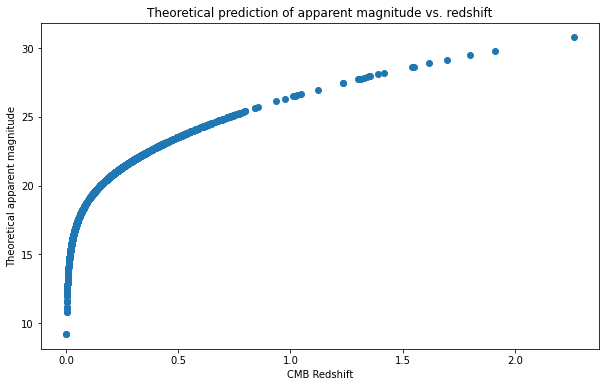

In [19]:
# Plot the theoretical prediction of the apparent magnitude vs redshift

plt.figure(figsize=(10, 6))

plt.scatter(z_values, m_model)
plt.title('Theoretical prediction of apparent magnitude vs. redshift') 
plt.xlabel('CMB Redshift')
plt.ylabel('Theoretical apparent magnitude')
plt.grid(False)
plt.show()

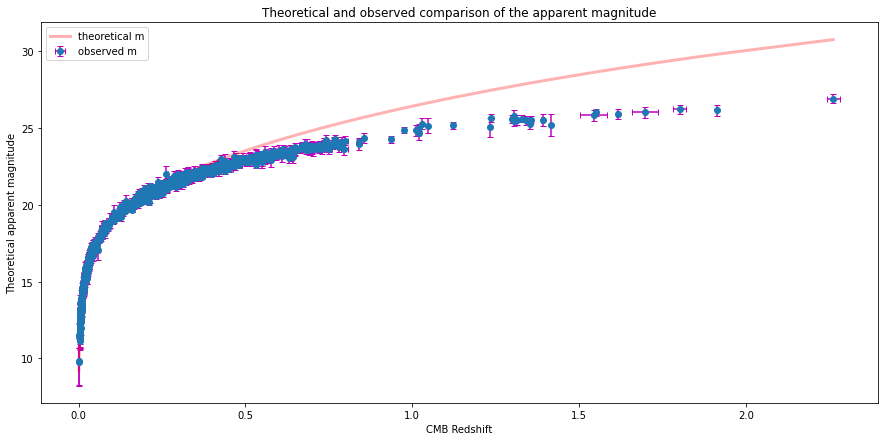

In [20]:
# Theoretical-observed comparison plot of the apparent magnitude

plt.figure(figsize=(15,7))

plt.errorbar(df['zCMB'], df['m_b_corr'], xerr=df['zCMBERR'], yerr=df['m_b_corr_err_DIAG'], fmt='o', ecolor='m', capsize=3)
# Plot the true line
plt.plot(z_values, m_model, "r", alpha=0.3, lw=3)
plt.title("Theoretical and observed comparison of the apparent magnitude")
legend = ("theoretical m","observed m")
plt.legend(legend)
plt.xlabel('CMB Redshift')
plt.ylabel('Theoretical apparent magnitude')
plt.savefig('magnitude.png')

### Chi-square $\chi^2$ statistic


The $\chi^2$ function defined as

$$
\chi^2_{sne}=\left[\mu_{i,data}-\mu_{model}(z_i)\right]\Sigma^{-1}_{sne,ij}\left[\mu_{j,data}-\mu_{model}(z_j)\right],
$$

where $\mu_{i,data}$ and $\mu_{model}(z_i)$ are the _observed_ and _predicted_ distance moduli at the redshift $z_i$, respectively; $\Sigma^{-1}_{sne,ij}$ is the supernova covariance matrix from the Pantheon+ SH0ES collaboration (considering both statistical and systematic errors). First, we explore the covariance matrix.

### Covariance matrix

The format of the covariance (.cov) file is $NxN$ lines, where the first line gives the number of rows/columns in the matrix ($N=1701$). We are interested in the Statistical+Systematic covariance matrix `STAT+SYS`, it includes all the covariance between SNe (and also Cepheid host covariance) due to systematic uncertainties. Let's import the matrix and transform it into a Numpy array format.

In [21]:
path = "/home/olesya/Документы/A_Rabota/Rabota/Cosmological Tensions/Data/Pantheon+SH0ES_STAT+SYS.cov"
cov_matrix = np.loadtxt(path)
n_sne = int(cov_matrix[0])
cov_matrix = cov_matrix[1:].reshape((n_sne, n_sne))

In [22]:
cov_matrix.shape

(1701, 1701)

In [23]:
cov_matrix[0]

array([ 3.177108e-02,  5.754430e-03,  3.100600e-04, ...,  2.945500e-04,
       -8.595000e-05, -2.701100e-04])

In [24]:
# Check for NaN elements
np.isnan(cov_matrix).sum()

0

In [25]:
# Check for +/- ininite values
np.isinf(cov_matrix).sum()

0

In [26]:
np.min(cov_matrix)

-0.03172511

### Likelihood

Through the $\chi^2$ we define the likelihood:

$$
\mathcal{L}_{sne}(H_0,q_0,j_0)=\mathcal{N}e^{-\frac{1}{2}\chi^{2}},
$$

where $\mathcal{N}=|2\pi\Sigma_{sne}|^{-\frac{1}{2}}$ is a normalization constant. The likelihood represents the probability of having a dataset given a cosmological model. We are interested in the contrary, i.e.
in the probability of having a certain cosmological model given a dataset. This is called **posterior probability**. 

Let's compute the Gaussian log-likelihood for the _observed_ and _predicted_ apparent magnitude at the redshift $z_i$, respectively. For now, we omit the normalization constant.

In [27]:
#df['m_b_corr'] to np.array

m_data = df['m_b_corr'].to_numpy()
m_data.shape

(1701,)

In [28]:
# Calculate the inverse of the covariance matrix  
cov_inv = np.linalg.inv(cov_matrix)

# Function to compute the logarithm of the likelihood, return L
def log_prob(cov_inv, m_data, m_model):
     
    return -0.5 * (np.dot((m_model- m_data) , np.dot(cov_inv , (m_model - m_data))))

In [29]:
cov_inv.shape

(1701, 1701)

In [30]:
# Call the function

likelihood_value = log_prob(cov_inv, m_data, m_model)
print("Likelihood:", likelihood_value)

Likelihood: -5429.066901696799


### Posterior probability 

In this section we will sample the posterior probability using the algorithm EMCEE to implement the Markov Chain Monte Carlo (MCMC) method. According to Bayes Theorem, the posterior probability is given by

$$ 
P(\theta|d) = \frac{P(d|\theta)P(\theta)}{P(d)}, 
$$

where:
- $\theta$ is the cosmological parameters and  $d$ is the observed data, or samples. 
- $P(\theta|d)$ is the posterior probability for $\theta$, and it represents our degree of belief about the value of $\theta$ after we have seen the data $d$. 
- $P(d|\theta)=\mathcal{L}(\theta)$ is the likelihood function we already encountered. It is the probability of the data given a certain value of the parameters.
- $P(\theta)$ is the prior probability distribution. It represents our degree of belief in the value of $\theta$ before we see the data (hence the name).
- $P(d)$ is a normalizing constant, or the evidence, it ensures that the posterior is normalized to unity:$$ P(d)=\int d \theta P(d|\theta)P(\theta).$$


In our case, the posterior probability for $H_0$, $q_0$ aand $j_0$ is given by
$$ 
P(H_0,q_0,j_0|SN) = \frac{P(H_0)P(q_0)P(j_0)\mathcal{L}((H_0,q_0,j_0))}{\mathcal{E}}, 
$$

where $\mathcal{E}$ is the evidence.

The purpose of a Markov chain Monte Carlo algorithm is to construct a sequence of points (or “samples”) in parameter space (called “a chain”). The crucial property of the chain is that the density of samples is proportional to the posterior pdf. This allows to construct a map of the posterior distribution.

To sample the posterior we use `emcee`, an open-source sampler for MCMC, and for analyzing the chains we use `getdist`.

In [31]:
ndim = 3
nwalkers = 10
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[m_data, cov_inv])

In [32]:
log_prob(p0[0], m_data, cov_inv)

ValueError: shapes (3,) and (1701,1701) not aligned: 3 (dim 0) != 1701 (dim 0)

In [ ]:
sampler.run_mcmc(p0, 10000)

## References

[1] David Camarena and Valerio Marra, _Local determination of the Hubble constant and the deceleration parameter_, Phys. Rev. Research 2, 013028 (2020).


[2] Oliver Piattella, _Lecture Notes in Cosmology_, Springer Cham (2018). 


[3] D. Foreman-Mackey, D. W. Hogg, D. Lang, and J. Goodman, _emcee: The MCMC Hammer_, Publ. Astron. Soc. Pac. 125 (2013) 306–312, https://arxiv.org/abs/1202.3665


[4] A. Lewis, _GetDist: a Python package for analysing Monte Carlo samples_, arXiv:1910.13970, https://getdist.readthedocs.io.